# RIWI Sport - Sales and Customer Analysis.

## 1. Setup and Data Loading

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text, inspect
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the parent directory to the system path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import custom database engine
from src.db.database import get_engine

# Set visualization style
sns.set_style("whitegrid")

# Get the database engine
engine = get_engine()

# Verify tables in the database
if engine:
    try:
        inspector = inspect(engine)
        table_names = inspector.get_table_names()
        print(f"Tables found in the database: {table_names}")
    except Exception as e:
        print(f"An error occurred while inspecting tables: {e}")

Database connection established successfully.
Tables found in the database: ['order_payment', 'address', 'customer', 'gender', 'order', 'order_status', 'payment_method', 'seller', 'order_item', 'product', 'category', 'role', 'access']


In [3]:
# SQL query to join all relevant tables into a single sales dataset
main_query = """
SELECT
    oi.id_order_item,
    o.id_order,
    o.payment_date,
    c.id_customer,
    c.full_name AS customer_name,
    c.email AS customer_email,
    a.city,
    a.department,
    p.id_product,
    p.name AS product_name,
    p.price AS product_price,
    cat.id_category,
    cat.name AS category_name,
    oi.amount AS quantity,
    oi.subtotal
FROM public.order_item oi
JOIN public."order" o ON oi.order_id = o.id_order
JOIN public.customer c ON o.customer_id = c.id_customer
JOIN public.address a ON c.address_id = a.id_address
JOIN public.product p ON oi.product_id = p.id_product
JOIN public.category cat ON p.category_id = cat.id_category
WHERE o.is_active = true AND c.is_active = true AND p.is_active = true;
"""

# Execute the query and load data into a pandas DataFrame
if engine:
    try:
        print("Fetching sales data from the database...")
        df_sales = pd.read_sql_query(main_query, engine)
        print("Data loaded successfully!")
        
        # Display basic info and the first few rows
        df_sales.info()
        display(df_sales.head())
        
    except Exception as e:
        print(f"An error occurred while fetching data: {e}")

Fetching sales data from the database...
Data loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   id_order_item   1496 non-null   int64              
 1   id_order        1496 non-null   int64              
 2   payment_date    1496 non-null   datetime64[ns, UTC]
 3   id_customer     1496 non-null   int64              
 4   customer_name   1496 non-null   object             
 5   customer_email  1496 non-null   object             
 6   city            1496 non-null   object             
 7   department      1496 non-null   object             
 8   id_product      1496 non-null   int64              
 9   product_name    1496 non-null   object             
 10  product_price   1496 non-null   float64            
 11  id_category     1496 non-null   int64              
 12  category_name   1496 no

,id_order_item,id_order,payment_date,id_customer,customer_name,customer_email,city,department,id_product,product_name,product_price,id_category,category_name,quantity,subtotal
0,1,1,2024-12-18 00:00:00+00:00,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,33,Raqueta Wilson Pro 33 encnp,290.0,5,Fitness,3,474.0
1,2,1,2024-12-18 00:00:00+00:00,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,253,Guayos Adidas Sport 253 0lugm,355.0,2,Baloncesto,3,1149.0
2,3,1,2024-12-18 00:00:00+00:00,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,586,Raqueta Head Professional 586 afdck,118.0,3,Tenis,1,190.0
3,4,1,2024-12-18 00:00:00+00:00,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,183,Guayos Puma Training 183 mh05c,448.0,5,Fitness,2,762.0
4,5,1,2024-12-18 00:00:00+00:00,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,313,Medias Adidas Competition 313 fjqoz,89.0,1,Fútbol,1,270.0


## 2. Data Cleaning and Preprocessing

In [4]:
# Check for missing values
print("Checking for null values...")
display(df_sales.isnull().sum())

# Check for duplicate rows
duplicate_rows = df_sales.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

Checking for null values...


id_order_item     0
id_order          0
payment_date      0
id_customer       0
customer_name     0
customer_email    0
city              0
department        0
id_product        0
product_name      0
product_price     0
id_category       0
category_name     0
quantity          0
subtotal          0
dtype: int64


Number of duplicate rows: 0


In [ ]:
# --- Feature Engineering ---

# Convert payment_date to datetime without timezone for simplicity
df_sales['payment_date'] = df_sales['payment_date'].dt.tz_localize(None)

# Extract time-based features
df_sales['year'] = df_sales['payment_date'].dt.year
df_sales['month'] = df_sales['payment_date'].dt.month
df_sales['day_of_week'] = df_sales['payment_date'].dt.day_name()

# Optimize memory by converting category_name to a categorical type
df_sales['category_name'] = df_sales['category_name'].astype('category')

# Display the DataFrame with new features
print("\nDataFrame after feature engineering:")
df_sales.info()
display(df_sales.head())


DataFrame after feature engineering:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id_order_item   1496 non-null   int64         
 1   id_order        1496 non-null   int64         
 2   payment_date    1496 non-null   datetime64[ns]
 3   id_customer     1496 non-null   int64         
 4   customer_name   1496 non-null   object        
 5   customer_email  1496 non-null   object        
 6   city            1496 non-null   object        
 7   department      1496 non-null   object        
 8   id_product      1496 non-null   int64         
 9   product_name    1496 non-null   object        
 10  product_price   1496 non-null   float64       
 11  id_category     1496 non-null   int64         
 12  category_name   1496 non-null   category      
 13  quantity        1496 non-null   int64         
 14  subtotal        14

,id_order_item,id_order,payment_date,id_customer,customer_name,customer_email,city,department,id_product,product_name,product_price,id_category,category_name,quantity,subtotal,year,month,day_of_week
0,1,1,2024-12-18,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,33,Raqueta Wilson Pro 33 encnp,290.0,5,Fitness,3,474.0,2024,12,Wednesday
1,2,1,2024-12-18,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,253,Guayos Adidas Sport 253 0lugm,355.0,2,Baloncesto,3,1149.0,2024,12,Wednesday
2,3,1,2024-12-18,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,586,Raqueta Head Professional 586 afdck,118.0,3,Tenis,1,190.0,2024,12,Wednesday
3,4,1,2024-12-18,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,183,Guayos Puma Training 183 mh05c,448.0,5,Fitness,2,762.0,2024,12,Wednesday
4,5,1,2024-12-18,50,Miguel Fernández González,miguel.fernández50@email.com,Itagüí,Antioquia,313,Medias Adidas Competition 313 fjqoz,89.0,1,Fútbol,1,270.0,2024,12,Wednesday


## 3. Key Performance Indicators (KPIs) Analysis

In [ ]:
# --- Data Aggregation for KPIs ---

# Aggregate data to the order level
df_orders = df_sales.groupby('id_order').agg(
    total_items=('quantity', 'sum'),
    order_value=('subtotal', 'sum'),
    id_customer=('id_customer', 'first'), # Customer ID is the same for all items in an order
    city=('city', 'first'),
    department=('department', 'first')
).reset_index()

# Aggregate data to the customer level
df_customers = df_orders.groupby('id_customer').agg(
    total_orders=('id_order', 'nunique'),
    total_spend=('order_value', 'sum'),
    city=('city', 'first'),
    department=('department', 'first')
).reset_index()

print("Order-level data:")
display(df_orders.head())

print("\nCustomer-level data:")
display(df_customers.head())

Order-level data:


,id_order,total_items,order_value,id_customer,city,department
0,1,10,2845.0,50,Itagüí,Antioquia
1,2,8,1847.0,25,Medellín,Antioquia
2,3,4,1217.0,19,Medellín,Antioquia
3,4,4,1590.0,8,Bello,Antioquia
4,5,7,1806.0,49,Medellín,Antioquia



Customer-level data:


,id_customer,total_orders,total_spend,city,department
0,1,11,19694.0,Bello,Antioquia
1,2,11,14577.0,Itagüí,Antioquia
2,3,8,12494.0,Medellín,Antioquia
3,4,12,15318.0,Itagüí,Antioquia
4,5,5,7737.0,Medellín,Antioquia


In [ ]:
# --- 3.1. Statistical KPIs ---

# -- Measures of Central Tendency (Customer Spend) --
mean_spend = df_customers['total_spend'].mean()
median_spend = df_customers['total_spend'].median()
mode_spend = df_customers['total_spend'].mode()[0] # Mode can have multiple values

print("--- Central Tendency of Total Spend per Customer ---")
print(f"Mean Spend: ${mean_spend:,.2f}")
print(f"Median Spend: ${median_spend:,.2f}")
print(f"Mode Spend: ${mode_spend:,.2f}\n")

# -- Measures of Dispersion (Customer Spend) --
variance_spend = df_customers['total_spend'].var()
std_dev_spend = df_customers['total_spend'].std()

print("--- Dispersion of Total Spend per Customer ---")
print(f"Variance of Spend: {variance_spend:,.2f}")
print(f"Standard Deviation of Spend: ${std_dev_spend:,.2f}\n")

# -- Interquartile Range (IQR) --
q1 = df_customers['total_spend'].quantile(0.25)
q3 = df_customers['total_spend'].quantile(0.75)
iqr = q3 - q1

print("--- Interquartile Range (IQR) of Customer Spend ---")
print(f"Q1 (25th Percentile): ${q1:,.2f}")
print(f"Q3 (75th Percentile): ${q3:,.2f}")
print(f"IQR: ${iqr:,.2f}\n")

--- Central Tendency of Total Spend per Customer ---
Mean Spend: $15,920.04
Median Spend: $14,261.50
Mode Spend: $3,082.00

--- Dispersion of Total Spend per Customer ---
Variance of Spend: 50,603,731.67
Standard Deviation of Spend: $7,113.63

--- Interquartile Range (IQR) of Customer Spend ---
Q1 (25th Percentile): $10,933.25
Q3 (75th Percentile): $21,025.75
IQR: $10,092.50



In [8]:
# --- 3.2. Business KPIs ---

# -- Average Order Value (AOV) --
aov_per_order = df_orders['order_value'].mean()
aov_per_customer = df_customers['total_spend'].mean() # This is the same as mean_spend calculated before

print("--- Average Order Value (AOV) ---")
print(f"AOV per Order (Ticket Promedio): ${aov_per_order:,.2f}")
print(f"Average Spend per Customer: ${aov_per_customer:,.2f}\n")

# -- Top 5 Categories by Revenue and Quantity --
top_categories_revenue = df_sales.groupby('category_name', observed=True)['subtotal'].sum().sort_values(ascending=False).head(5)
top_categories_quantity = df_sales.groupby('category_name', observed=True)['quantity'].sum().sort_values(ascending=False).head(5)

print("--- Top 5 Categories by Revenue ---")
display(top_categories_revenue)

print("\n--- Top 5 Categories by Quantity Sold ---")
display(top_categories_quantity)

# -- Top 5 Products by Revenue and Quantity --
top_products_revenue = df_sales.groupby('product_name')['subtotal'].sum().sort_values(ascending=False).head(5)
top_products_quantity = df_sales.groupby('product_name')['quantity'].sum().sort_values(ascending=False).head(5)

print("\n--- Top 5 Products by Revenue ---")
display(top_products_revenue)

print("\n--- Top 5 Products by Quantity Sold ---")
display(top_products_quantity)

# -- Product/Category with Highest Price Variability --
# Let's check variability within categories, as individual product prices might be static.
price_variability_category = df_sales.groupby('category_name', observed=True)['product_price'].std().sort_values(ascending=False)

print("\n--- Price Variability (Standard Deviation) within Categories ---")
display(price_variability_category)

--- Average Order Value (AOV) ---
AOV per Order (Ticket Promedio): $1,592.00
Average Spend per Customer: $15,920.04

--- Top 5 Categories by Revenue ---


category_name
Tenis         132212.0
Baloncesto    125623.0
Accesorios    113500.0
Fútbol        109016.0
Fitness       106451.0
Name: subtotal, dtype: float64


--- Top 5 Categories by Quantity Sold ---


category_name
Tenis         497
Baloncesto    463
Accesorios    444
Fútbol        425
Fitness       412
Name: quantity, dtype: int64


--- Top 5 Products by Revenue ---


product_name
Pantalón Puma Premium 687 cm0gs          4630.0
Raqueta Adidas Professional 443 0w3h6    3909.0
Balón Mizuno Modern 174 whfnj            3506.0
Gorra Spalding Sport 685 kbbsp           3480.0
Raqueta Spalding Premium 731 323kb       3445.0
Name: subtotal, dtype: float64


--- Top 5 Products by Quantity Sold ---


product_name
Raqueta Adidas Professional 443 0w3h6    16
Pantalón Puma Premium 687 cm0gs          16
Balón Mizuno Modern 174 whfnj            14
Shorts Adidas Professional 614 4ag7k     12
Camiseta Reebok Competition 338 mlft2    12
Name: quantity, dtype: int64


--- Price Variability (Standard Deviation) within Categories ---


category_name
Fútbol        163.425544
Tenis         149.711285
Accesorios    145.443636
Running       145.378426
Baloncesto    133.480511
Natación      130.890110
Fitness       128.766822
Name: product_price, dtype: float64

In [ ]:
# --- 3.3. Additional Metrics ---

# Import the shapiro function from scipy
from scipy.stats import shapiro

# -- Coefficient of Variation (CV) for Customer Spend --
# CV is useful to compare dispersion between datasets with different means. CV = std / mean
cv_spend = (std_dev_spend / mean_spend)
print("--- Coefficient of Variation (CV) for Customer Spend ---")
print(f"CV: {cv_spend:.2%}")
print("Interpretation: A CV of this magnitude suggests a high degree of variability in customer spending relative to the average.\n")

# -- Normality Test for Customer Spend --
stat, p_value = shapiro(df_customers['total_spend'])

print("--- Normality Test (Shapiro-Wilk) for Customer Spend ---")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value > alpha:
    print("Sample looks Gaussian (fail to reject H0).")
else:
    print("Sample does not look Gaussian (reject H0). This is expected for sales data.")

--- Coefficient of Variation (CV) for Customer Spend ---
CV: 44.68%
Interpretation: A CV of this magnitude suggests a high degree of variability in customer spending relative to the average.

--- Normality Test (Shapiro-Wilk) for Customer Spend ---
P-value: 0.1224
Sample looks Gaussian (fail to reject H0).


## 4. Data Visualization

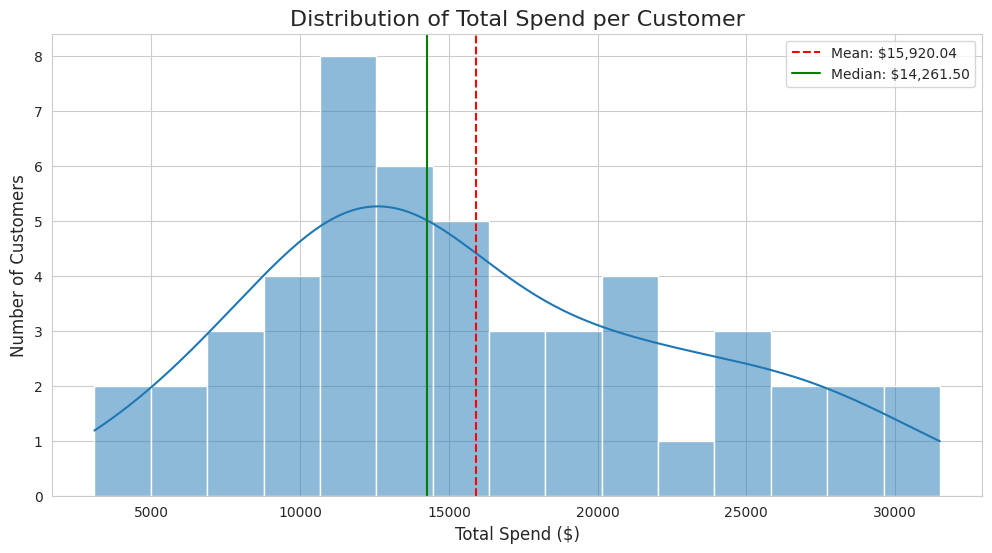

In [10]:
# --- 4.1. Customer Spend Distribution ---

plt.figure(figsize=(12, 6))
sns.histplot(df_customers['total_spend'], kde=True, bins=15)

# Add lines for mean and median
plt.axvline(mean_spend, color='red', linestyle='--', label=f'Mean: ${mean_spend:,.2f}')
plt.axvline(median_spend, color='green', linestyle='-', label=f'Median: ${median_spend:,.2f}')

plt.title('Distribution of Total Spend per Customer', fontsize=16)
plt.xlabel('Total Spend ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend()
plt.show()

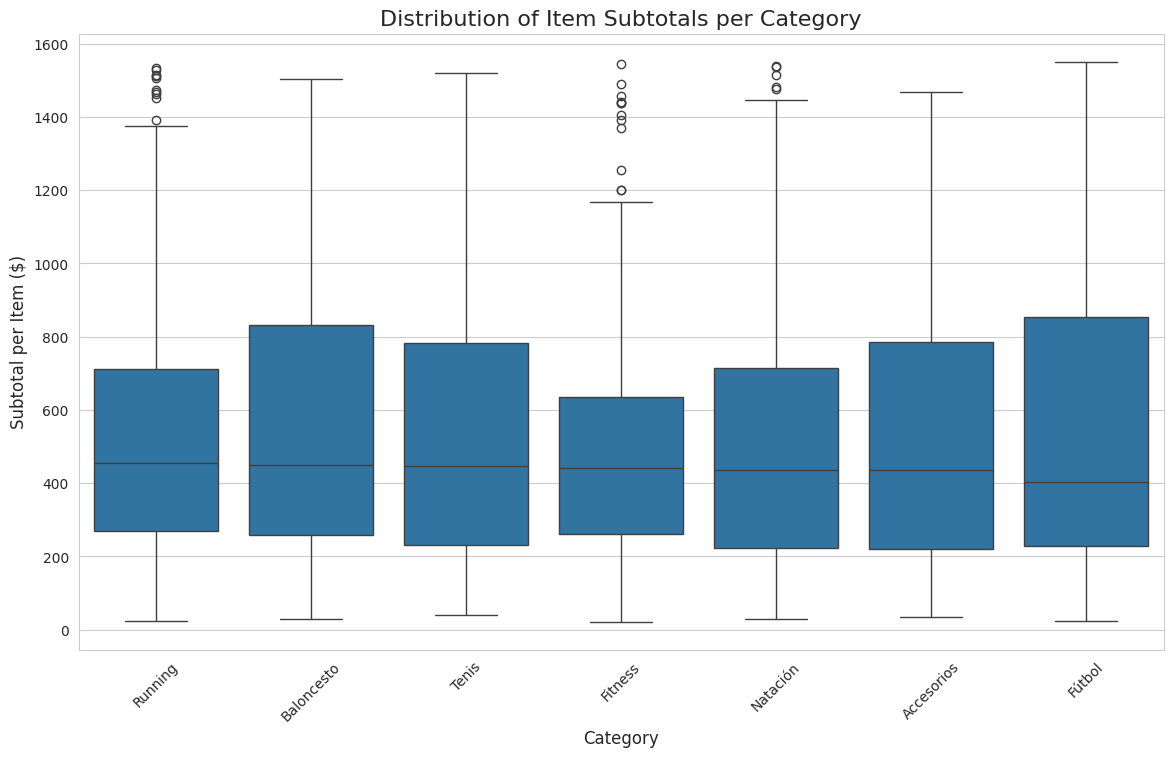

In [ ]:
# --- 4.2. Sales Distribution by Category ---

# Order categories by median subtotal for better visualization
median_order = df_sales.groupby('category_name', observed=True)['subtotal'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.boxplot(x='category_name', y='subtotal', data=df_sales, order=median_order)

plt.title('Distribution of Item Subtotals per Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Subtotal per Item ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

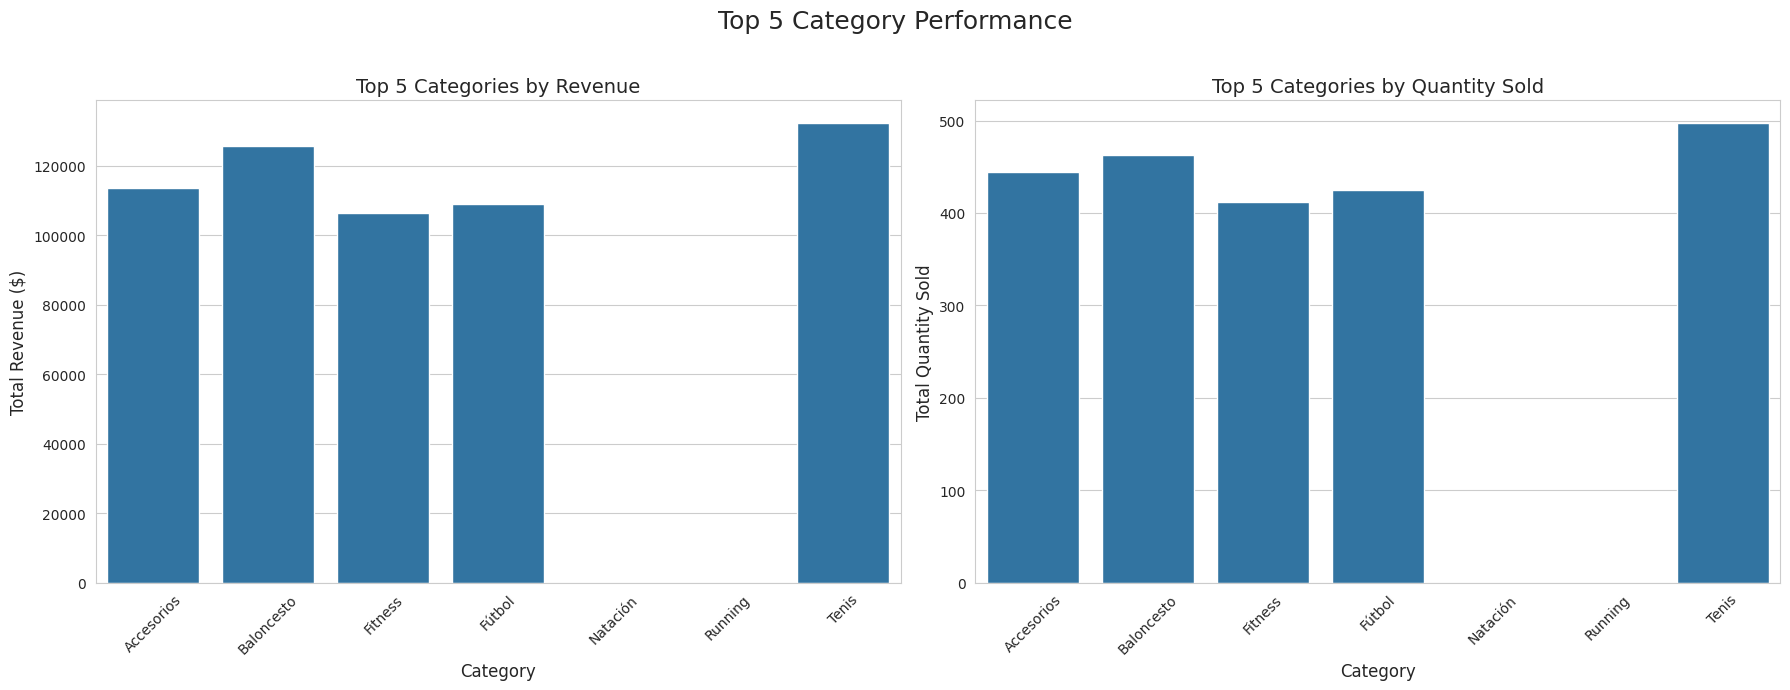

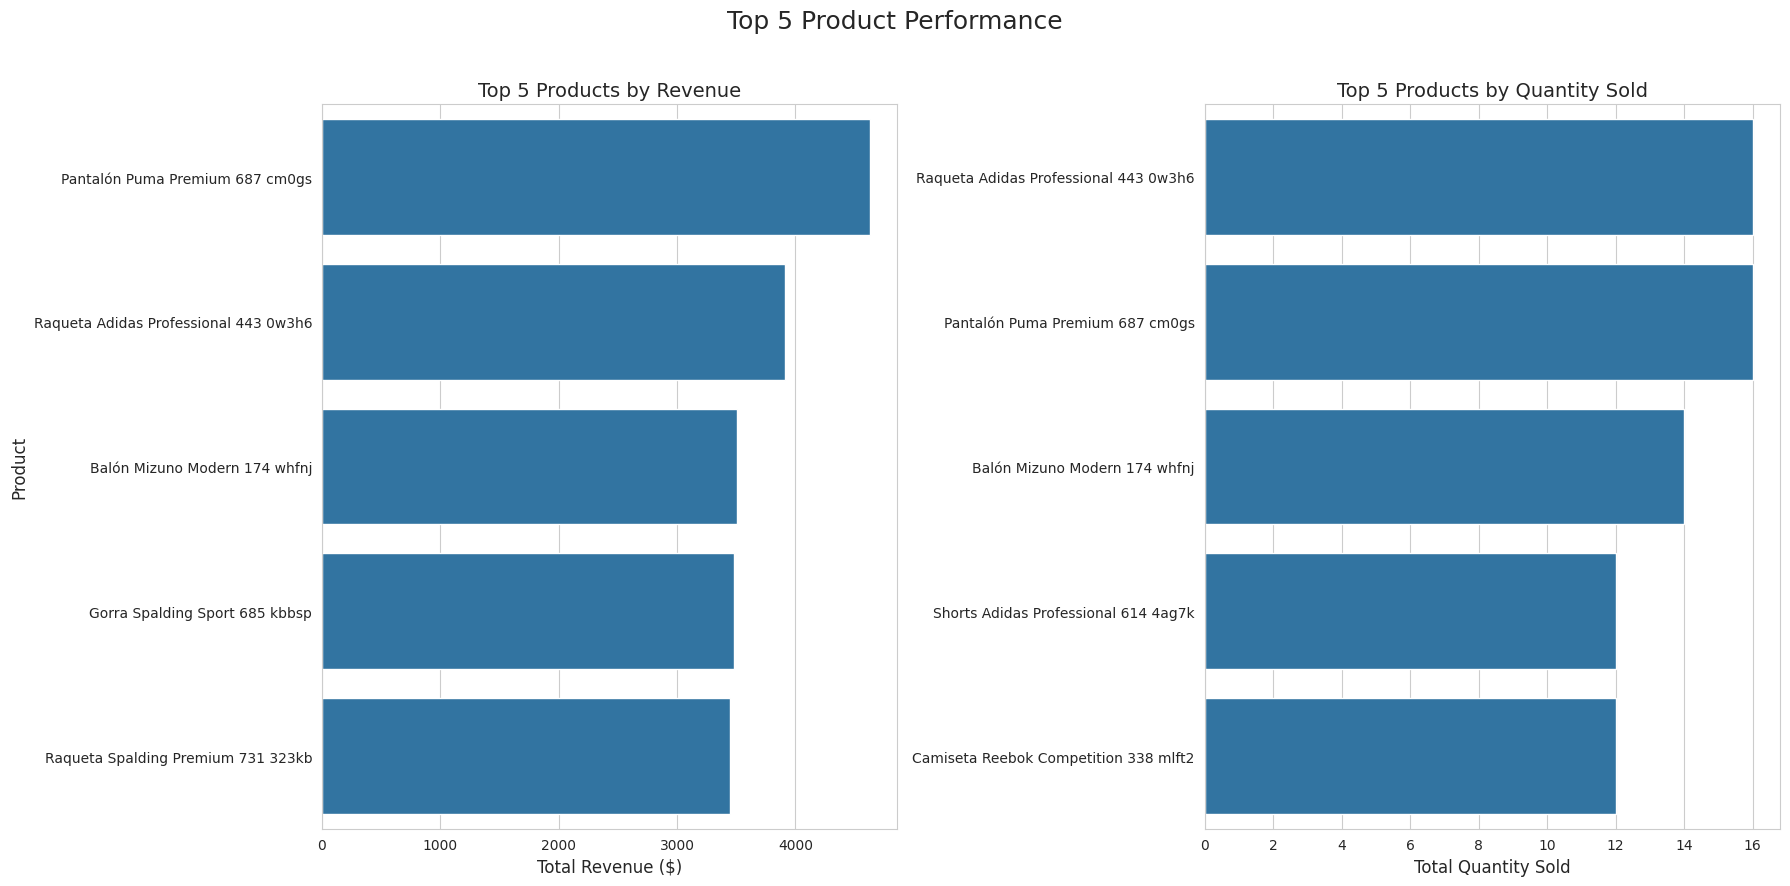

In [ ]:
# --- 4.3. Top 5 Categories & Products ---

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top 5 Categories by Revenue
sns.barplot(ax=axes[0], x=top_categories_revenue.index, y=top_categories_revenue.values)
axes[0].set_title('Top 5 Categories by Revenue', fontsize=14)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Total Revenue ($)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Top 5 Categories by Quantity
sns.barplot(ax=axes[1], x=top_categories_quantity.index, y=top_categories_quantity.values)
axes[1].set_title('Top 5 Categories by Quantity Sold', fontsize=14)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Total Quantity Sold', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Top 5 Category Performance', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

# Now for Top 5 Products
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Top 5 Products by Revenue
sns.barplot(ax=axes[0], y=top_products_revenue.index, x=top_products_revenue.values, orient='h')
axes[0].set_title('Top 5 Products by Revenue', fontsize=14)
axes[0].set_xlabel('Total Revenue ($)', fontsize=12)
axes[0].set_ylabel('Product', fontsize=12)

# Top 5 Products by Quantity
sns.barplot(ax=axes[1], y=top_products_quantity.index, x=top_products_quantity.values, orient='h')
axes[1].set_title('Top 5 Products by Quantity Sold', fontsize=14)
axes[1].set_xlabel('Total Quantity Sold', fontsize=12)
axes[1].set_ylabel('') # Hide y-label for cleaner look

plt.suptitle('Top 5 Product Performance', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Executive Summary & Recommendation

### Main Insight: Market Duality in the "Fitness" Category

**1. Observation (What):**  
Although the **"Fitness"** category has the lowest median transaction value among all categories, our distribution analysis (boxplot) reveals that it also has the **highest concentration of very high-value transactions (outliers)**. This indicates a **bimodal price structure** within the same category.

**2. Interpretation (Why):**  
This duality suggests that **"Fitness" serves two radically different customer profiles**:

- A **mass market segment** that purchases low-cost, high-turnover products  
  *(e.g., resistance bands, apparel, small accessories).*
- A **premium niche segment** that invests in high-value, durable equipment  
  *(e.g., cardio machines, advanced weight sets).*

The current commercial strategy may be **suboptimized** by not differentiating communication and offerings between these two segments, resulting in a **loss of sales potential in the high-value niche**.

**3. Actionable Recommendation (What to Do):**  
We recommend **segmenting the commercial strategy for the "Fitness" category** to capitalize on the dual nature of its customers:

* **For the Premium Segment**
  - **Action:** Launch targeted digital marketing campaigns (email + social media) aimed at customers who have already purchased high-value items. Promote complementary accessories or new premium releases.
  - **Success Metric:** Increase repurchase rate among high-value customers by **20% within the next 6 months**.

* **For the Mass Segment**
  - **Action:** Boost volume sales with **bundle offers** or **starter kits**  
  *(e.g., “Beginner Yoga Kit”)* to increase average order value (AOV).
  - **Success Metric:** Increase **AOV of Fitness orders below the median by 10%**.


## 6. Exploratory Segmentation (Bonus)

--- Performance by City ---


,city,total_revenue,number_of_customers,number_of_orders,avg_spend_per_customer,aov_per_order
0,Medellín,389172.0,25,248,15566.880000,1569.241935
1,Itagüí,214086.0,13,130,16468.153846,1646.815385
2,Bello,192744.0,12,122,16062.000000,1579.868852


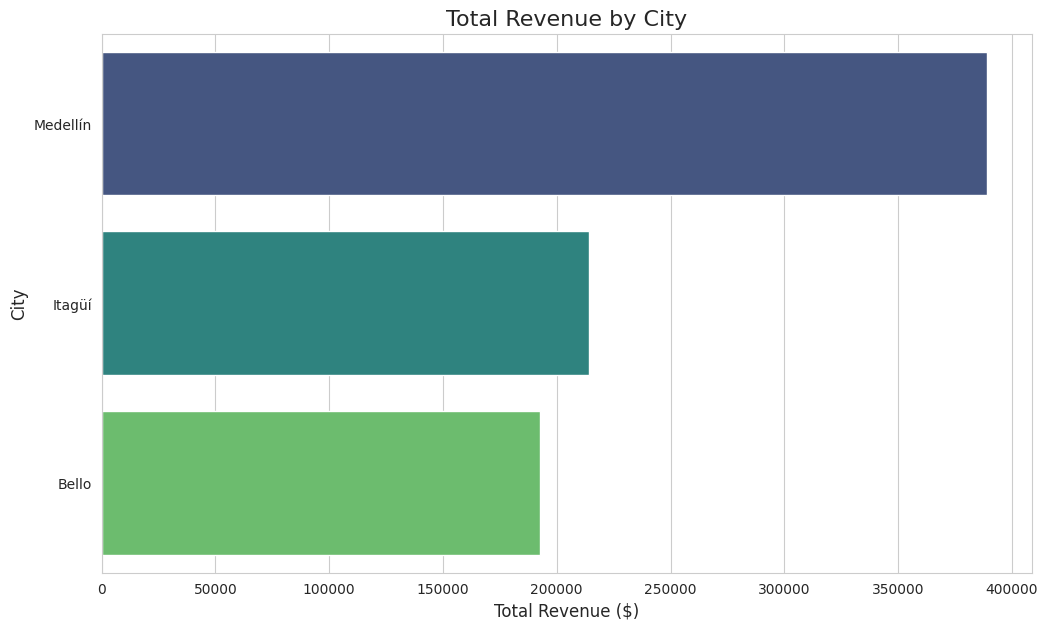

In [13]:
# --- 6.1. Segmentation by City ---

# Aggregate sales data by city
city_performance = df_sales.groupby('city').agg(
    total_revenue=('subtotal', 'sum'),
    number_of_customers=('id_customer', 'nunique'),
    number_of_orders=('id_order', 'nunique')
).sort_values(by='total_revenue', ascending=False).reset_index()

# Calculate average spend per customer and AOV per city
city_performance['avg_spend_per_customer'] = city_performance['total_revenue'] / city_performance['number_of_customers']
city_performance['aov_per_order'] = city_performance['total_revenue'] / city_performance['number_of_orders']

print("--- Performance by City ---")
display(city_performance)

# Visualize Total Revenue by City
plt.figure(figsize=(12, 7))
sns.barplot(x='total_revenue', y='city', data=city_performance, orient='h', palette='viridis', hue='city', legend=False)
plt.title('Total Revenue by City', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.show()


--- Revenue Pivot Table: City vs. Category ---


category_name,Accesorios,Baloncesto,Fitness,Fútbol,Natación,Running,Tenis
city,,,,,,,
Bello,27722.0,26825.0,21117.0,32053.0,26937.0,24712.0,33378.0
Itagüí,23062.0,36067.0,36617.0,35383.0,29431.0,28044.0,25482.0
Medellín,62716.0,62731.0,48717.0,41580.0,49188.0,50888.0,73352.0


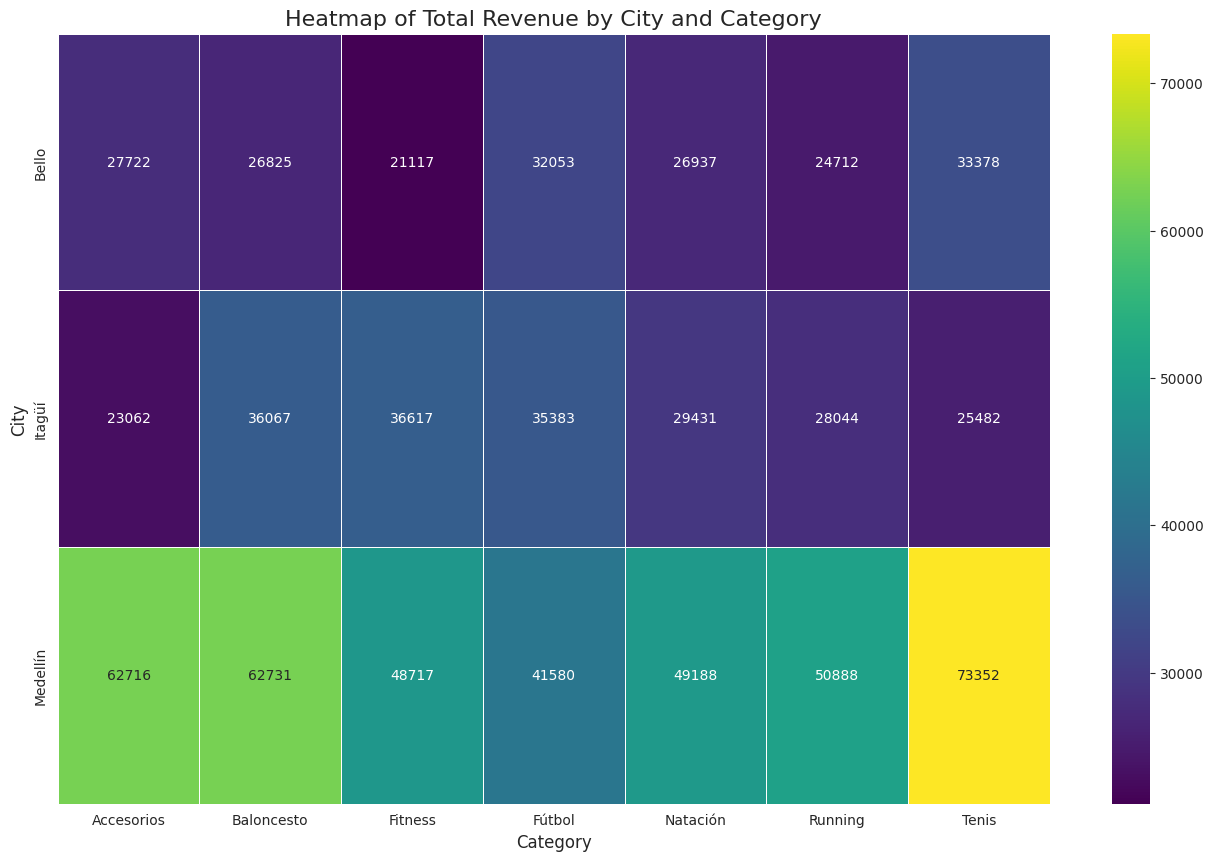

In [14]:
# --- 6.2. Segmentation by City and Category ---

# Create a pivot table to see revenue for each category in each city
city_category_pivot = df_sales.pivot_table(
    index='city', 
    columns='category_name', 
    values='subtotal', 
    aggfunc='sum',
    fill_value=0,  # Fill cities/categories with no sales with 0
    observed=True
)

print("\n--- Revenue Pivot Table: City vs. Category ---")
display(city_category_pivot)

# Visualize the pivot table as a heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    city_category_pivot, 
    annot=True,        # Show the numbers in the cells
    fmt=".0f",         # Format numbers as integers
    cmap='viridis',    # Use a color-blind friendly palette
    linewidths=.5
)

plt.title('Heatmap of Total Revenue by City and Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.show()

## 7. Code Refactoring for Reusability (Bonus)

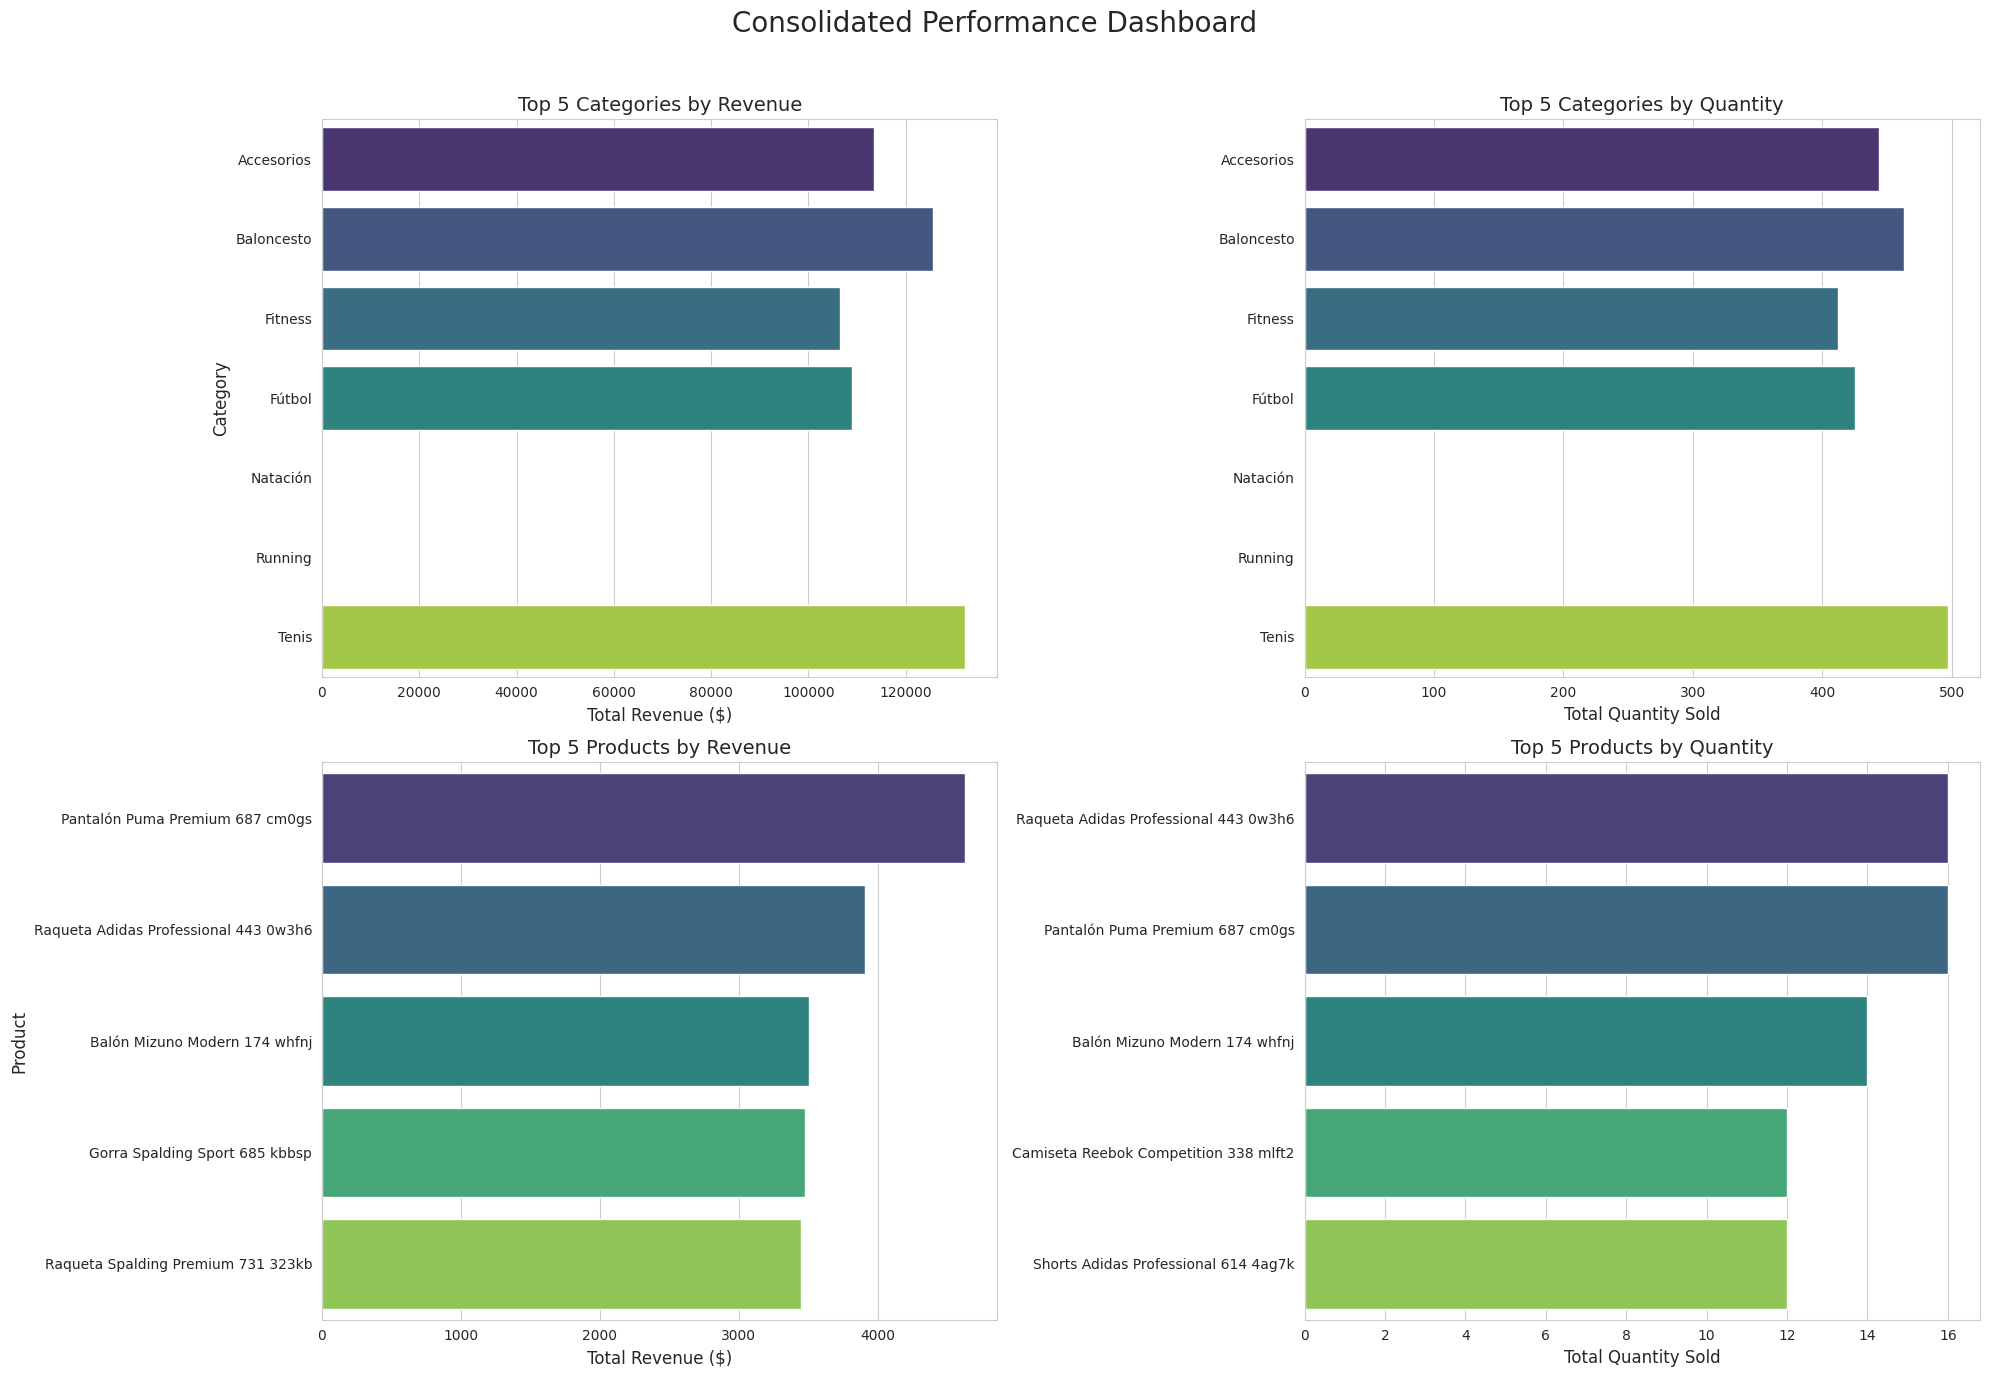

In [15]:
def plot_top_n(data, n, x_col, y_col, title, xlabel, ylabel, ax):
    """
    Generate a horizontal bar plot to show the top N of a category.

    Args:
        data (pd.DataFrame): DataFrame containing the data to plot.
        n (int): Number of items to show (e.g., 5 for Top 5).
        x_col (str): Name of the column for the X axis (numeric values).
        y_col (str): Name of the column for the Y axis (categories).
        title (str): Plot title.
        xlabel (str): Label for the X axis.
        ylabel (str): Label for the Y axis.
        ax (matplotlib.axes.Axes): The subplot where the plot will be drawn.
    """
    top_data = data.nlargest(n, x_col)
    sns.barplot(ax=ax, x=x_col, y=y_col, data=top_data, orient='h', hue=y_col, palette='viridis', dodge=False, legend=False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

# --- Data Preparation for Dashboard ---
category_agg_data = df_sales.groupby(['id_category', 'category_name'], observed=True).agg(
    total_revenue=('subtotal', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()

product_agg_data = df_sales.groupby(['id_product', 'product_name']).agg(
    total_revenue=('subtotal', 'sum'),
    total_quantity=('quantity', 'sum')
).reset_index()


# --- Use of the Reusable Function ---
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Chart 1: Top 5 Categories by Revenue
plot_top_n(category_agg_data, 5, 'total_revenue', 'category_name', 
           'Top 5 Categories by Revenue', 'Total Revenue ($)', 'Category', axes[0, 0])

# Chart 2: Top 5 Categories by Quantity
plot_top_n(category_agg_data, 5, 'total_quantity', 'category_name', 
           'Top 5 Categories by Quantity', 'Total Quantity Sold', '', axes[0, 1])

# Chart 3: Top 5 Products by Revenue
plot_top_n(product_agg_data, 5, 'total_revenue', 'product_name', 
           'Top 5 Products by Revenue', 'Total Revenue ($)', 'Product', axes[1, 0])

# Chart 4: Top 5 Products by Quantity
plot_top_n(product_agg_data, 5, 'total_quantity', 'product_name', 
           'Top 5 Products by Quantity', 'Total Quantity Sold', '', axes[1, 1])


plt.suptitle('Consolidated Performance Dashboard', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()